In [1]:
import numpy as np
import pandas as pd
import re

#Visualisation Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from pandas.plotting import scatter_matrix

#Training and Preprocessing Libraries
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [2]:
class_names = ['Fatal', 'Severe', 'Slight']


In [3]:
data1 = pd.read_csv("./data/accidents_2005_to_2007.csv")
data2 = pd.read_csv("./data/accidents_2009_to_2011.csv")
data3 = pd.read_csv("./data/accidents_2012_to_2014.csv")

In [4]:
data = pd.concat([data1, data2, data3])


In [5]:
type(data)
print(data.head(0))

Empty DataFrame
Columns: [Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Date, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Detail, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site, Carriageway_Hazards, Urban_or_Rural_Area, Did_Police_Officer_Attend_Scene_of_Accident, LSOA_of_Accident_Location, Year]
Index: []

[0 rows x 33 columns]


In [7]:
def max_val(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

year_wise_casualties = data.groupby(['Year'])['Number_of_Casualties'].sum()
year_wise_casualties = year_wise_casualties.reset_index()
year_wise_casualties = year_wise_casualties.style.apply(max_val, axis=0)
year_wise_casualties

,Year,Number_of_Casualties
0,2005,271017
1,2006,258404
2,2007,247780
3,2009,222146
4,2010,208648
5,2011,203950
6,2012,241954
7,2013,183670
8,2014,194477


In [8]:
cas_table = data.groupby(['Day_of_Week']).agg({'Number_of_Casualties':['sum'],'Speed_limit':['min','max']})
cas_table = cas_table.sort_values([('Number_of_Casualties','sum')],ascending=False)
cas_table = cas_table.reset_index()
cas_table.style.apply(max_val)

In [9]:
corr_matrix = data.corr()
corr_matrix["Accident_Severity"].sort_values(ascending=False)

Accident_Severity             1.000000
Number_of_Vehicles            0.075976
2nd_Road_Class                0.064321
2nd_Road_Number               0.026128
Longitude                     0.013946
Location_Easting_OSGR         0.013465
1st_Road_Class                0.012754
Day_of_Week                   0.002961
1st_Road_Number              -0.004072
Year                         -0.005907
Latitude                     -0.031357
Location_Northing_OSGR       -0.031395
Police_Force                 -0.031712
Local_Authority_(District)   -0.031995
Speed_limit                  -0.079108
Urban_or_Rural_Area          -0.082169
Number_of_Casualties         -0.083544
Junction_Detail                    NaN
Name: Accident_Severity, dtype: float64

In [6]:
# 30/11/2007
def convert_date_to_day_of_year(dt):
    result = re.findall(r'(\d{2})/(\d{2})/(\d{4})',dt)
    return result[0][0]
   
def convert_date_to_month(dt):
    result = re.findall(r'(\d{2})/(\d{2})/(\d{4})',dt)
    return result[0][1]

In [7]:
data['day_of_year'] = data.Date.apply(lambda x: convert_date_to_day_of_year(x))
data['month'] = data.Date.apply(lambda x: convert_date_to_month(x))


In [12]:
# data.hist(bins=50, figsize=(20,15))
# plt.show()

In [13]:
# fig = data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.6,
#                    figsize=(18,11),c="Accident_Severity", cmap=plt.get_cmap("inferno"), 
#                    colorbar=True,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f6b7c88>,
      dtype=object)

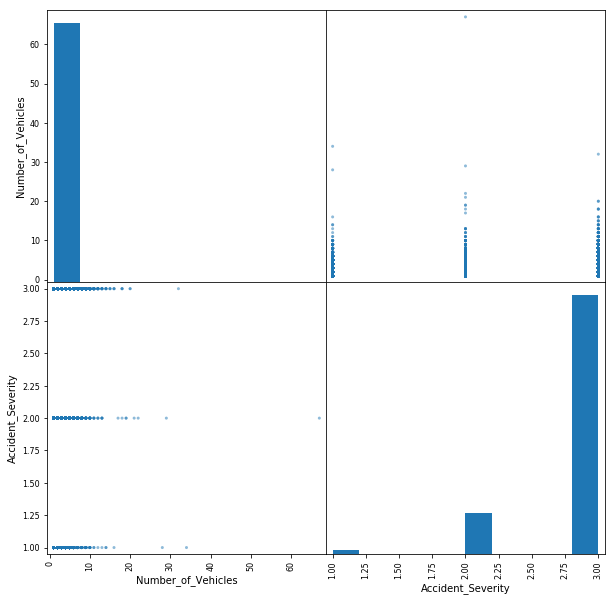

In [8]:
attributes = ["Number_of_Vehicles", "Time", "Road_Type", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Accident_Severity"]
scatter_matrix(data[attributes], figsize=(10, 10))




In [9]:
drop_columns = ['Date', 'Accident_Index', 'Number_of_Casualties', 'Police_Force', 'Junction_Detail', 'Junction_Control', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Local_Authority_(District)', 'Local_Authority_(Highway)']

In [10]:
data1 = data.drop(drop_columns, axis=1, inplace=False)
data1.dropna(inplace=True)

In [11]:
#Drop rows with 'Unknown' values
data1 = data1[data1.Weather_Conditions!='Unknown']
data1 = data1[data1.Road_Type!='Unknown']

In [12]:
#Encode "String" Labels into "Int" Labels for easy training
le = LabelEncoder()
data1["Pedestrian_Crossing-Physical_Facilities"]= le.fit_transform(data1["Pedestrian_Crossing-Physical_Facilities"])
data1["Light_Conditions"]= le.fit_transform(data1["Light_Conditions"])
data1["Weather_Conditions"] = le.fit_transform(data1["Weather_Conditions"])
data1["Road_Surface_Conditions"] = le.fit_transform(data1["Road_Surface_Conditions"])
data1["Pedestrian_Crossing-Human_Control"] = le.fit_transform(data1["Pedestrian_Crossing-Human_Control"])
data1["Road_Type"] = le.fit_transform(data1["Road_Type"])

#Converting Time into Int for easy training
data1["Time"]= data1["Time"].astype(str)
data1['Time']=data1['Time'].str.slice(0,2, 1)
data1["Time"]= data1["Time"].astype(int)

In [13]:
print(data1[:5])

   Location_Easting_OSGR  Location_Northing_OSGR  Longitude   Latitude  \
0               525680.0                178240.0  -0.191170  51.489096   
1               524170.0                181650.0  -0.211708  51.520075   
2               524520.0                182240.0  -0.206458  51.525301   
3               526900.0                177530.0  -0.173862  51.482442   
4               528060.0                179040.0  -0.156618  51.495752   

   Accident_Severity  Number_of_Vehicles  Day_of_Week  Time  1st_Road_Class  \
0                  2                   1            3    17               3   
1                  3                   1            4    17               4   
2                  3                   2            5     0               5   
3                  3                   1            6    10               3   
4                  3                   1            2    21               6   

   1st_Road_Number  ...  2nd_Road_Number  Pedestrian_Crossing-Human_Control  \
0

In [14]:
print(data1["Accident_Severity"][10:20])
# print(le.fit_transform(data["Accident_Severity"])[100:200])

10    3
11    3
12    3
13    3
14    3
15    3
16    2
17    3
18    3
19    2
Name: Accident_Severity, dtype: int64


In [15]:
train,test = train_test_split(data1,test_size=.25)

In [16]:
# def preprocessing(data):
#     #Drop useless columns and nan values
#     data.drop(drop_columns, axis=1, inplace=True)
#     data.dropna(inplace=True)
    
#     #Drop rows with 'Unknown' values
#     data = data[data.Weather_Conditions!='Unknown']
#     data = data[data.Road_Type!='Unknown']
    
#     #Encode "String" Labels into "Int" Labels for easy training
#     le = LabelEncoder()
#     data["Pedestrian_Crossing-Physical_Facilities"]= le.fit_transform(data["Pedestrian_Crossing-Physical_Facilities"])
#     data["Light_Conditions"]= le.fit_transform(data["Light_Conditions"])
#     data["Weather_Conditions"] = le.fit_transform(data["Weather_Conditions"])
#     data["Road_Surface_Conditions"] = le.fit_transform(data["Road_Surface_Conditions"])
#     data["Pedestrian_Crossing-Human_Control"] = le.fit_transform(data["Pedestrian_Crossing-Human_Control"])
#     data["Road_Type"] = le.fit_transform(data["Road_Type"])
    
#     #Converting Time into Int for easy training
#     data["Time"]= data["Time"].astype(str)
#     data['Time']=data['Time'].str.slice(0,2, 1)
#     data["Time"]= data["Time"].astype(int)
    
#     #Creating 3 additional columns, one each for each class we need to classify into
# #     onehot = pd.get_dummies(data.Accident_Severity,prefix=['Severity'])
    
# #     data["Fatal"] = onehot["['Severity']_1"]
# #     data["Severe"] = onehot["['Severity']_2"]
# #     data["Slight"] = onehot["['Severity']_3"]
    
#     #Finally splitting the data into train and test
#     train,test = train_test_split(data,test_size=.25)
    
#     return (train,test)

In [17]:
# train,test = preprocessing(data1)


In [18]:
train_features = train[["Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Year", "Urban_or_Rural_Area"]]
test_features =test[["Number_of_Vehicles", "Day_of_Week", "Time", "Road_Type", "Speed_limit", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions","Year", "Urban_or_Rural_Area"]]

In [19]:
predicted_classes = []

In [20]:
print(train.shape)

(1100994, 23)


In [21]:
y_train = train['Accident_Severity']
# x_train = train.loc[:, train.columns != 'Accident_Severity']
x_train = train_features


In [22]:
y_test = test['Accident_Severity'] 
# x_test = test.loc[:, train.columns != 'Accident_Severity']
x_test = test_features

In [23]:
print(test.loc[:, train.columns != 'Accident_Severity'].head(0))

Empty DataFrame
Columns: [Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Number_of_Vehicles, Day_of_Week, Time, 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Urban_or_Rural_Area, Year, day_of_year, month]
Index: []

[0 rows x 22 columns]


In [24]:
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (1100994, 12)
x_test:  (366998, 12)
y_train:  (1100994,)
y_test:  (366998,)


In [25]:
print(x_test[1:10], x_train[1:10])

        Number_of_Vehicles  Day_of_Week  Time  Road_Type  Speed_limit  \
263992                   2            6    17          3           60   
289470                   2            7    10          3           40   
333583                   2            5    12          3           30   
465762                   2            4    13          3           30   
260698                   2            6     8          3           30   
301606                   2            3    17          3           30   
293585                   2            4    10          3           30   
43700                    3            6    13          3           60   
513477                   1            6    14          3           60   

        Pedestrian_Crossing-Human_Control  \
263992                                  2   
289470                                  2   
333583                                  2   
465762                                  2   
260698                                  2   

In [26]:
print(y_test[1:10], y_train[1:10])

263992    3
289470    2
333583    3
465762    3
260698    3
301606    3
293585    3
43700     2
513477    3
Name: Accident_Severity, dtype: int64 379277    3
367815    3
508655    3
418031    3
275106    2
165244    3
403483    3
313016    3
351145    1
Name: Accident_Severity, dtype: int64


In [27]:
def classify(clf, X_train, Y_train, X_test):
    print('_' * 80)
    print("Training: ")
    print(clf)
#     t0 = time()
    clf.fit(X_train, Y_train)
#     train_time = time() - t0
#     print("train time: %0.3fs" % train_time)
    
#     t0 = time()
    pred = clf.predict(X_test)
#     test_time = time() - t0
#     print("test time:  %0.3fs" % test_time)
    print(type(pred))
    return pred

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score


In [29]:
pred = classify(RandomForestClassifier(), x_train, y_train, x_test)

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
<class 'numpy.ndarray'>


In [30]:
pred1 = classify(KNeighborsClassifier(n_neighbors=4), x_train, y_train, x_test)

________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')
<class 'numpy.ndarray'>


In [31]:
pred2 = classify(GradientBoostingClassifier(), x_train, y_train, x_test)

________________________________________________________________________________
Training: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
<class 'numpy.ndarray'>


In [32]:
f1_score(y_test, pred2, average='macro')

/Users/varunshah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.30652796275645244

In [33]:
f1_score(y_test, pred1, average='macro')

0.35213066475447247

In [34]:
f1_score(y_test, pred, average='macro')

0.34326809163949595

In [ ]:
def model():
    scores=[]
    acc_score=[]
    submission = pd.DataFrame.from_dict({'Accident_Index': test['Accident_Index']})
    classifier = EasyEnsembleClassifier(n_estimators=12, base_estimator=XGBClassifier(max_depth=4, learning_rate=0.2, n_estimators=600, silent=True,
                        subsample = 0.8,
                        gamma=0.5,
                        min_child_weight=10,
                        objective='binary:logistic',
                        colsample_bytree = 0.6,
                        max_delta_step = 1,
                        nthreads=1,
                        n_jobs=1))
    
    for class_name in class_names:
        train_target = train[class_name]

        cv_score = np.mean(cross_val_score(
            classifier, train_features, train_target, cv=3, scoring='roc_auc'))
        scores.append(cv_score)
        print('CV score for class {} is {}'.format(class_name, cv_score))

        classifier.fit(train_features, train_target)
        
        submission[class_name] = classifier.predict_proba(test_features)[:, 1]
        acc = roc_auc_score(test[class_name],submission[class_name])
        acc_score.append(acc)
        print('Mean accuracy for class {} is {}'.format(class_name,acc))
    
    return (scores,acc_score)


In [ ]:
# cv, acc = model()

In [ ]:
# print('Total CV score is {}'.format(np.mean(cv)))
# print('Total accuracy score is {}'.format(np.mean(acc)))